In [1]:
import pandas as pd
import DataLoading
import NN_classes
import torch
import matplotlib.pyplot as plt

In [2]:
sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w_ext_o_dummy/"
all_executions = DataLoading.list_executions(folder=folder,per = period,sc=sc)
te_s = 0.3
val_s = 0.4

In [3]:
dfs_in, dfs_out, dfs_inter = DataLoading.load_data_ext_out(folder, all_executions, period, sc, ["PowerFlow"])

input_f_sc01_Network_Existing_Generation_Full_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_106_N_108_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_106_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_107_N_108_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_108_N_109_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_108_N_110_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_109_N_111_cac1_2030.csv
86
input_f_sc01_Network_Line_In_N_109_N_112_cac1_2030.csv
86
input_f_sc01_N

In [4]:
dfs_inter_j = DataLoading.join_frames_inter_layer(dfs_inter)
dfs_inter_j = DataLoading.trim_columns_to_common(dfs_inter_j)
# Convert to pytorch tensors
ts_in, ts_out, ts_inter = DataLoading.split_tr_val_te_ext_out(dfs_in, dfs_out, dfs_inter_j, all_executions, te_s, val_s)
d_ft_in, d_ft_out, d_ft_inter,maxs = DataLoading.concat_and_normalize_ext_out(ts_in, ts_out, ts_inter, all_executions)

input_size = dfs_in["Network_Existing_Generation_Full"].shape[1]
inter_size = dfs_inter_j["Network_Existing_Generation_Full"].shape[1]

In [5]:
def calculate_lb_from_dfs_out(dfs_out,execution): 
    return (dfs_out["Network_Existing_Generation_Full"].sum(axis=1) - dfs_out[execution].sum(axis=1))
def find_xthbest_model_params_from_df(df_losses,loss_to_sort,xth_best=1):
    return df_losses.sort_values(by =loss_to_sort)[xth_best-1:xth_best]

def create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name):
    #First, extract params from row
    model_type = row.Model_type.item()
    model_type = tuple(map(int, model_type.replace("(","").replace(")","").split(', ')))
    dor = row.Dor.item()
    lr = row.Lr.item()
    nb_e = row.Epochs.item()

    relu_out = row.Relu_out.item()
    np =row.Np.item()
    bs = row.Batch_size.item()

    if row.Min_val.item(): 
        mt = "min_val"
    else: 
        mt = "all_epochs"
    
    #Then create model of given type
    m = NN_classes.create_model(model_type,input_size, dropout_ratio= dor,relu_out =relu_out,inter=True,inter_size=inter_size)
    
    #Finally, extract model state from dict
    
    m_name = f"OE_{model_type}h_{nb_e}e_{lr}lr_{dor}dor_{np}np_{relu_out}_ro_{bs}bs"
    path = f"ResultsClusterRuns/trained_models/RTS24_AC_12w_dummy_{hyperloop_name}_0_40/{mt}/model_{m_name}.pth"

    m.load_state_dict(torch.load(path))
    m.eval()
    
    return m

In [8]:
#Find model with best loss from csv file 
hyperloop_name = "All_Exec_dummy_t0.3_v0.4_PF_sa"
df_losses = pd.read_csv(f"ResultsClusterRuns/Loss_results_csv/{hyperloop_name}.csv",index_col=0)
f = df_losses.Np ==0

loss_to_sort = "Te_l_t_mse"

xth_best = 2
row = find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
m = create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name)

[172, 258, 62, 38, 19, 9]


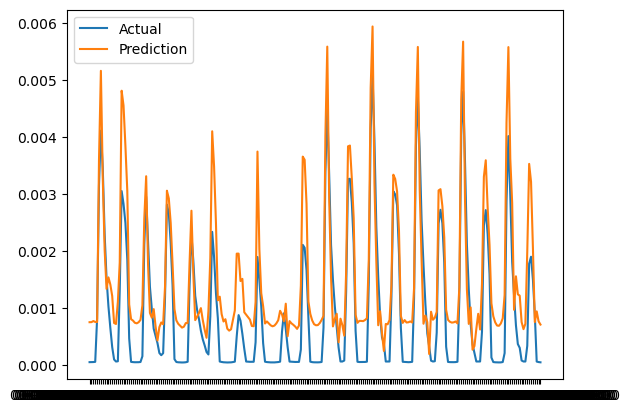

In [9]:
#Visual sanity check
ex = all_executions[0]
data_part = "train"
actual = calculate_lb_from_dfs_out(dfs_out,ex)

ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])
ex_out_1 = ts_out[data_part][ex]
ex_out = dfs_out[ex].sum(axis=1)

prediction = m(ex_in.float())[0].detach().numpy()

s = 0
e=s+240
plt.plot(ex_out[s:e],label = "Actual")
plt.plot(prediction[s:e],label = "Prediction")

plt.legend()

[172, 258, 62, 38, 19, 9]


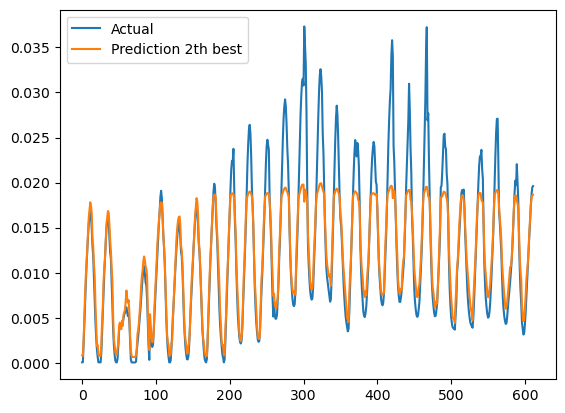

In [41]:
#Visualisation of multiple models 
ex = all_executions[32]
data_part = "val"
actual = calculate_lb_from_dfs_out(dfs_out,ex)
ex_in = torch.nan_to_num(ts_in[data_part][ex]/maxs["in"])
ex_out_1 = ts_out[data_part][ex]
s = 0
e=s+5000
plt.plot(ex_out_1[s:e],label = "Actual")

for xth_best in [2]: 
    row = find_xthbest_model_params_from_df(df_losses[f],loss_to_sort,xth_best)
    m = create_model_and_load_state_from_row(row,input_size,inter_size,hyperloop_name)
    prediction = m(ex_in.float())[0].detach().numpy()
    plt.plot(prediction[s:e],label = f"Prediction {xth_best}th best")
plt.legend()


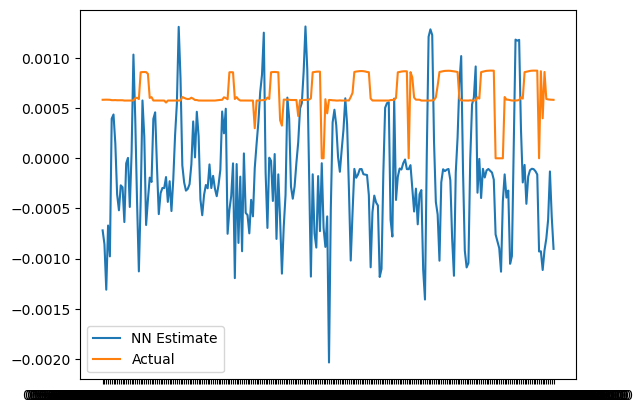

In [38]:
#Find estimated line benefit 

ex = all_executions[32]
negf = all_executions[0]


ex_in_e = torch.nan_to_num(torch.concat((ts_in["train"][ex],ts_in["test"][ex],ts_in["val"][ex]))/maxs["in"])
ex_in_negf = torch.nan_to_num(torch.concat((ts_in["train"][negf],ts_in["test"][negf],ts_in["val"][negf]))/maxs["in"])

prediction_e = m(ex_in_e.float())[0].detach().numpy()
prediction_negf = m(ex_in_negf.float())[0].detach().numpy()

lb_est = prediction_e-prediction_negf
lb_actual = calculate_lb_from_dfs_out(dfs_out,ex)


#ex_out = dfs_out[e].sum(axis=1)

s=1000
e = s+250
plt.plot(lb_est[s:e],label = "NN Estimate")
plt.plot(lb_actual[s:e],label = "Actual")
plt.legend()

In [134]:
#Compare losses with the ones reported in the results file 



torch.Size([612, 86])

torch.Size([2184, 86])